In [1]:
# Cell 1: Import Libraries and Load Processed Data (Tensors)
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd # For creating a DataFrame for metrics later
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np # For RMSE calculation
import matplotlib.pyplot as plt
import os # For saving model/tensors

# Define the path to your saved tensors
processed_data_path = 'data/processed_tensors' # Ensure this aligns with your project structure

try:
    X_train_tensor = torch.load(f'{processed_data_path}/X_train_tensor.pt')
    y_train_tensor = torch.load(f'{processed_data_path}/y_train_tensor.pt')
    X_test_tensor = torch.load(f'{processed_data_path}/X_test_tensor.pt')
    y_test_tensor = torch.load(f'{processed_data_path}/y_test_tensor.pt')

    print("PyTorch Tensors loaded successfully!")
    print("Shapes:")
    print("X_train_tensor:", X_train_tensor.shape)
    print("y_train_tensor:", y_train_tensor.shape)
    print("X_test_tensor:", X_test_tensor.shape)
    print("y_test_tensor:", y_test_tensor.shape)

    # Determine the number of input features for the model
    input_features = X_train_tensor.shape[1]
    print(f"Number of input features: {input_features}")

except FileNotFoundError:
    print(f"Error: One or more tensor files not found in {processed_data_path}. Please ensure they were saved correctly.")
    # Define placeholders if files are not found, so subsequent cells don't immediately error
    # But you'll need to fix the loading to proceed with actual training.
    input_features = 0 # Placeholder
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = [torch.empty(0)]*4

PyTorch Tensors loaded successfully!
Shapes:
X_train_tensor: torch.Size([3207, 3643])
y_train_tensor: torch.Size([3207, 1])
X_test_tensor: torch.Size([802, 3643])
y_test_tensor: torch.Size([802, 1])
Number of input features: 3643


In [4]:
# Cell 2: Define the PyTorch Model Architecture
class PricePredictor(nn.Module):
    def __init__(self, num_input_features):
        super(PricePredictor, self).__init__()
        self.layer_1 = nn.Linear(num_input_features, 128) # Input layer to hidden layer 1
        self.relu1 = nn.ReLU()
        self.layer_2 = nn.Linear(128, 64)                # Hidden layer 1 to hidden layer 2
        self.relu2 = nn.ReLU()
        self.output_layer = nn.Linear(64, 1)             # Hidden layer 2 to output layer

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu1(x)
        x = self.layer_2(x)
        x = self.relu2(x)
        x = self.output_layer(x)
        return x

# Ensure input_features is defined from Cell 1 before running this
if input_features > 0:
    model = PricePredictor(input_features)
    print("\nModel architecture defined:")
    print(model)
else:
    print("\nCannot define model: input_features is 0. Check data loading in Cell 1.")


Model architecture defined:
PricePredictor(
  (layer_1): Linear(in_features=3643, out_features=128, bias=True)
  (relu1): ReLU()
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [3]:
# Cell 3: Intanstiate Model, Define Loss Function not Optimizer
if 'model' in locals(): # Check if model was instantiated
    # Loss Function
    criterion = nn.MSELoss() # Mean Squared Error Loss for regression

    # Optimizer
    learning_rate = 0.001 # You can tune this hyperparameter
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print("\nModel instance created.")
    print(f"Loss function: {criterion}")
    print(f"Optimizer: Adam with learning rate {learning_rate}")
else:
    print("\nModel not instantiated. Check Cell 2.")


Model instance created.
Loss function: MSELoss()
Optimizer: Adam with learning rate 0.001



Starting training...
Epoch [20/200], Loss: 4480920064.0000
Epoch [40/200], Loss: 4480920064.0000
Epoch [60/200], Loss: 4480920064.0000
Epoch [80/200], Loss: 4480920064.0000
Epoch [100/200], Loss: 4480920064.0000
Epoch [120/200], Loss: 4480920064.0000
Epoch [140/200], Loss: 4480920064.0000
Epoch [160/200], Loss: 4480920064.0000
Epoch [180/200], Loss: 4480920064.0000
Epoch [200/200], Loss: 4480920064.0000
Training complete.


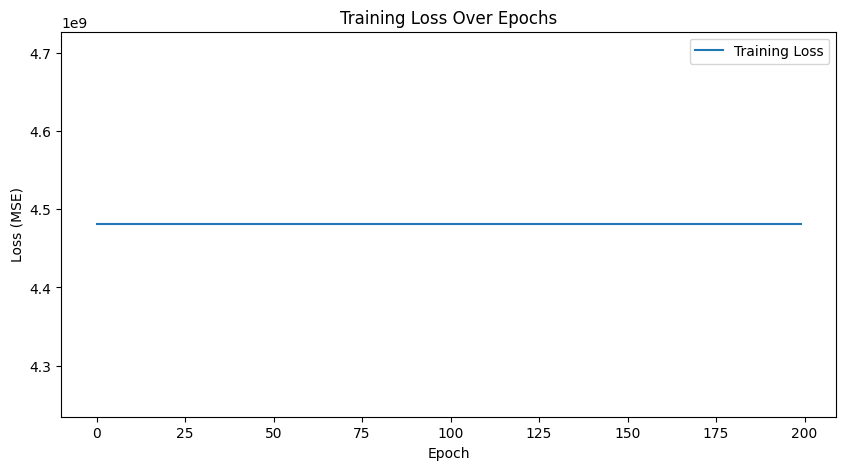

In [5]:
# Cell 4: Implement the Training Loop
if model is not None and criterion is not None and optimizer is not None and X_train_tensor.nelement() > 0:
    epochs = 200 # Number of times to iterate over the entire training dataset
    # For larger datasets, you might use PyTorch DataLoaders and batching here.
    # This example trains on the full dataset at once per epoch for simplicity in prototyping.

    print("\nStarting training...")
    train_losses = []

    for epoch in range(epochs):
        model.train() # Set the model to training mode

        # Forward pass: Get predictions
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor) # Calculate loss

        # Backward pass and optimization
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()       # Compute gradients based on the loss
        optimizer.step()      # Update model weights

        train_losses.append(loss.item()) # Record loss

        if (epoch + 1) % 20 == 0: # Print loss every 20 epochs
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    print("Training complete.")

    # Plot training loss
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
else:
    print("\nCannot start training. Ensure model, criterion, optimizer, and training data are ready from previous cells.")


--- Model Evaluation on Test Set ---
Mean Absolute Error (MAE): 50261.1914
Mean Squared Error (MSE): 22965757952.0000
Root Mean Squared Error (RMSE): 151544.5741
R-squared (R2 Score): -0.1236


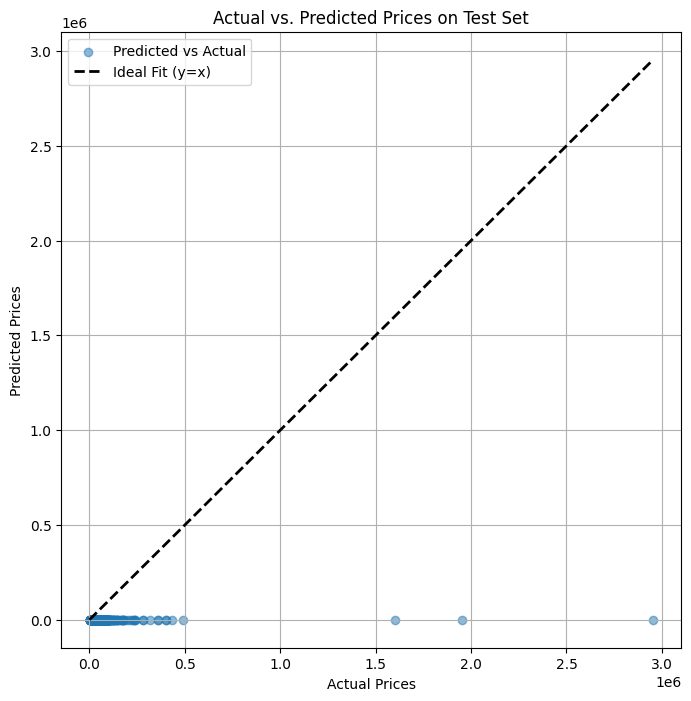

In [6]:
# Cell 5: Model Evaluation on Test Set
if model is not None and X_test_tensor.nelement() > 0:
    model.eval() # Set the model to evaluation mode
    
    with torch.no_grad(): # Deactivate autograd engine for evaluation
        y_pred_tensor = model(X_test_tensor)

    # Convert tensors to NumPy arrays for scikit-learn metrics
    y_test_np = y_test_tensor.numpy()
    y_pred_np = y_pred_tensor.numpy()

    # Calculate metrics
    mae = mean_absolute_error(y_test_np, y_pred_np)
    mse = mean_squared_error(y_test_np, y_pred_np)
    rmse = np.sqrt(mse) # Calculate RMSE from MSE
    r2 = r2_score(y_test_np, y_pred_np)

    print("\n--- Model Evaluation on Test Set ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2 Score): {r2:.4f}")

    # Scatter plot of Actual vs. Predicted values
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5, label='Predicted vs Actual')
    # Plot a diagonal line y=x for reference
    min_val = min(y_test_np.min(), y_pred_np.min())
    max_val = max(y_test_np.max(), y_pred_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit (y=x)')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices on Test Set')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nCannot evaluate model. Ensure model is trained and test data is available.")

In [7]:
# Cell 6: Save the Trained Model (Optional but Recommended)
if model is not None:
    model_save_path = 'saved_models' # Ensure this path aligns with your project structure
    os.makedirs(model_save_path, exist_ok=True) # Create directory if it doesn't exist
    
    model_filename = 'price_predictor_model_v1.pth'
    full_model_path = os.path.join(model_save_path, model_filename)
    
    try:
        torch.save(model.state_dict(), full_model_path)
        print(f"\nTrained model state_dict saved to: '{full_model_path}'")
    except Exception as e:
        print(f"Error saving model: {e}")
else:
    print("\nModel not available for saving.")


Trained model state_dict saved to: 'saved_models\price_predictor_model_v1.pth'
